# Recitation 5: non-homogeneous Poisson processes

* Sampling from non-homogeneous Poisson processes
* Revision for the mid-term exam

## Non-homogeneous Poisson processes (Inversion method)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

NH-PP with intensity $2$

In [2]:
def generate_unit_homogeneous_pp_arrivals(max_t):
    arrivals = []
    t = 0
    while True:
        t += np.random.exponential(1)
        if t > max_t:
            break
        arrivals.append(t)
    return np.array(arrivals)

In [3]:
generate_unit_homogeneous_pp_arrivals(10)

array([2.22929416, 2.74868323, 5.48352981, 6.74466099, 8.85644012,
       9.60865051])

To generate arrivals from a PP with intensity $\lambda(t)=2$, we can just take these and divide by 2

In [4]:
pp2_arrivals = generate_unit_homogeneous_pp_arrivals(10*2) / 2

(array([5., 3., 3., 4., 7.]),
 array([0.17111977, 1.9928589 , 3.81459802, 5.63633714, 7.45807626,
        9.27981538]),
 <BarContainer object of 5 artists>)

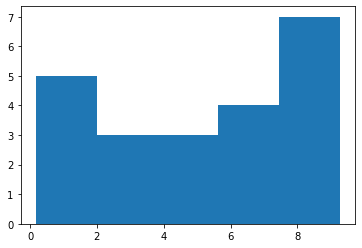

In [5]:
plt.hist(pp2_arrivals, bins=5)

$$\Lambda(t)=2t$$

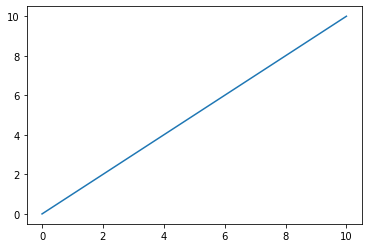

In [6]:
t = np.linspace(0, 10, 100)
plt.plot(t, t)

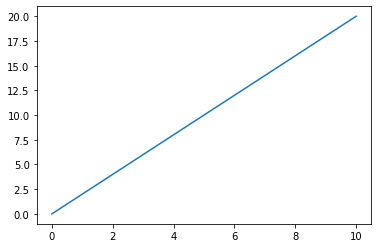

In [7]:
t = np.linspace(0, 10, 100)
plt.plot(t, 2*t)

In [8]:
def lambda3(t):
    return t**2

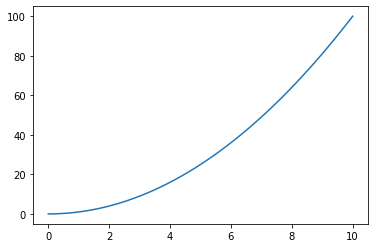

In [9]:
plt.plot(t, [lambda3(t_) for t_ in t])

In [10]:
def Lambda3(t):
    return t**3/3

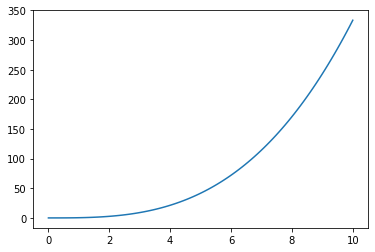

In [11]:
plt.plot(t, [Lambda3(t_) for t_ in t])

In [12]:
def Lambda3inv(t):
    return (3*t)**(1.0/3)

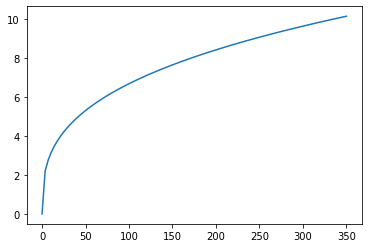

In [13]:
plt.plot(35*t, [Lambda3inv(t_) for t_ in 35*t])

In [14]:
arrivals = Lambda3inv(generate_unit_homogeneous_pp_arrivals(350))

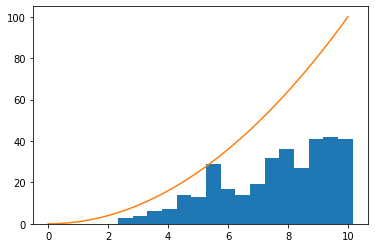

In [15]:
plt.hist(arrivals, bins=16)
plt.plot(t, [lambda3(t_) for t_ in t])

# Midterm exam revision

## Sympy

In [16]:
import sympy as sp

In [17]:
t = sp.Symbol("t")
T = sp.Symbol("T")
y = sp.Symbol("y")

In [18]:
eqn = t**3/3

In [19]:
sp.Integral(eqn, (t, 0, T)).doit()

T**4/12

In [20]:
sp.solve(eqn-y, t)

[3**(1/3)*y**(1/3),
 -3**(1/3)*y**(1/3)/2 - 3**(5/6)*I*y**(1/3)/2,
 -3**(1/3)*y**(1/3)/2 + 3**(5/6)*I*y**(1/3)/2]

Inverse:

We want $f^{-1}(y)$ for a given $y$. E.g. if $y=2$, we want to solve for $x$ in

$$f(x)=2$$

In other words, we want to solve for

$$f(x)-2=0$$

Or, in generality:

For arbitrary $y$, we want to solve $$f(x)-y=0$$

In [21]:
sols = sp.solve(eqn-y, t)

In [22]:
sols

[3**(1/3)*y**(1/3),
 -3**(1/3)*y**(1/3)/2 - 3**(5/6)*I*y**(1/3)/2,
 -3**(1/3)*y**(1/3)/2 + 3**(5/6)*I*y**(1/3)/2]

In [23]:
sol = sols[0]

In [24]:
func = sp.lambdify(y, sol)

In [25]:
sol

3**(1/3)*y**(1/3)

In [26]:
func(3)

2.080083823051904

## Composition method

Idea: it's basically conditional variables.

E.g:

The "intelligence" ($i$) of students is a Uniform(0,1) random variable, and their exam score is a Binomial($n, i$) random variable. Then the exam score is a composition.

## `pynverse`

In [27]:
%pip install pynverse

Note: you may need to restart the kernel to use updated packages.


In [28]:
from pynverse import inversefunc

In [29]:
def func(t):
    if t > 2:
        return 4+(t-2)**2
    else:
        return 2*t

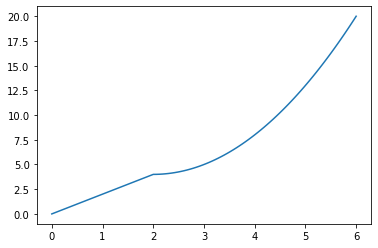

In [30]:
x = np.linspace(0, 6, 100)
plt.plot(x, [func(x_) for x_ in x])

In [31]:
inv_func = inversefunc(func)

In [32]:
inv_func(10)

array(4.44948977)

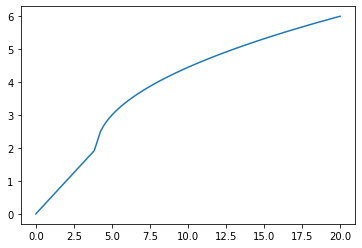

In [33]:
y = np.linspace(0, 20, 100)
plt.plot(y, [inv_func(y_) for y_ in y])

## Accept-reject sampling

### Goal:

Come up with a sampling algorithm to sample from a tricky pdf

In [34]:
def pdf(t):
    return np.exp(t**2) / 1.669526846

In [35]:
t_min = 0.1
t_max = 1.1

In [36]:
def pdf2(t):
    return 5*t**2 / 2.2250841750841754

In [37]:
c = 26.923156680046688

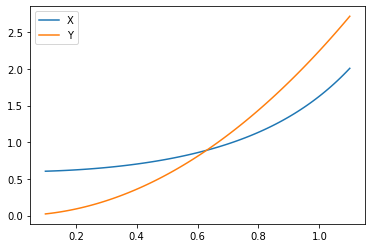

In [38]:
t = np.linspace(t_min, t_max, 100)
plt.plot(t, pdf(t))
plt.plot(t, pdf2(t))
plt.legend(["X", "Y"])

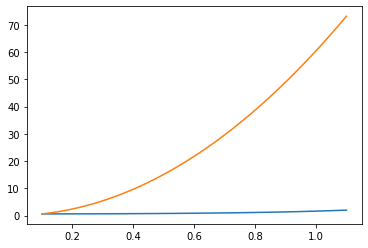

In [39]:
t = np.linspace(t_min, t_max, 100)
plt.plot(t, pdf(t))
plt.plot(t, c*pdf2(t))

In [40]:
tt = sp.Symbol("tt")
T = sp.Symbol("T")
sol = sp.Integral(5*tt**2 / 2.2250841750841754, (tt, 0, T)).doit()
CDF = sp.lambdify(T, sol)

In [41]:
inv_CDF = inversefunc(CDF)

In [42]:
inv_CDF

<function pynverse.inverse.inversefunc.<locals>.inv(yin)>

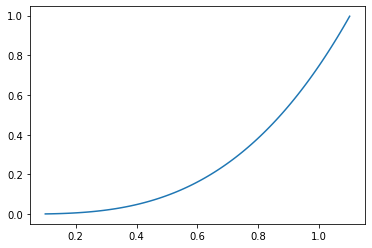

In [43]:
plt.plot(t, CDF(t))

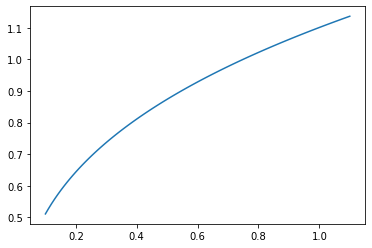

In [44]:
plt.plot(t, inv_CDF(t))
# CDF

In [45]:
def sample_helper():
    return float(inv_CDF(np.random.rand()))

In [46]:
samples = [sample_helper() for _ in range(1000)]

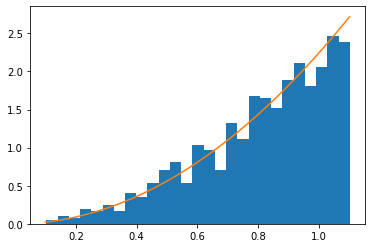

In [47]:
plt.hist(samples, density=True, bins=27)
t = np.linspace(t_min, t_max, 100)
plt.plot(t, pdf2(t))

We want to sample from $X$ which has pdf $f_X(t)$ but $F_X$ (the CDF) is hard to get.

But we have a $Y$ which is "close" to $X$, and we have an easy way to sample from $Y$.

In [48]:
def sample_from_hard(n):
    count = 0
    samples = []
    while count < n:
        Y = sample_helper()
        u = np.random.rand()
        accept_prob = pdf(Y) / (c * pdf2(Y))
        if u < accept_prob:
            samples.append(Y)
            count += 1
    return samples

In [49]:
samples_from_X = sample_from_hard(1000)

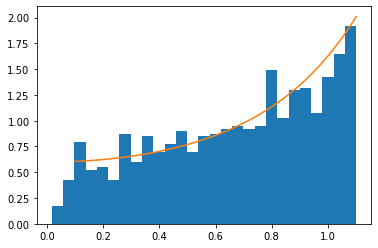

In [50]:
plt.hist(samples_from_X, density=True, bins=27)
t = np.linspace(t_min, t_max, 100)
plt.plot(t, pdf(t))

In [51]:
def sample_from_hard(n):
    count = 0
    samples = []
    iterations = 0
    while count < n:
        iterations += 1
        Y = sample_helper()
        u = np.random.rand()
        accept_prob = pdf(Y) / (c * pdf2(Y))
        if u < accept_prob:
            samples.append(Y)
            count += 1
    return samples, iterations

In [52]:
samples_from_X, iters = sample_from_hard(1000)

In [53]:
iters / len(samples_from_X)

27.143

In [54]:
c

26.923156680046688